## Fund Analysis to Predict Top Performing Mutual Funds

Topic Name : Mutual Fund Predictive Analytics

Team memebers:
    Ashwini Patil (ashwini.acpce@gmail.com)
    Rupesh More (rupeshmore85@gmail.com)

Data for the notebook is stored at the following location on github: Github Repository
In this notebook, we will read the fund data from CSV files which we created in earlier notebook fund_web_Scraping.ipynb using Web scraping of Morning Star website. Thereafter we will use data analysis and regression, Random Forest to predict Top performing funds which are good for investment.
We have collected past 10 years data of over 1000 funds. We will analyze the value of alpha, beta, return, R squared, sharpe ratio, standard deviation, expense ratio for each fund for 3 years, 5 years and 10 years and fit a model to predict top performing funds which are good for investment. We will also determine the relationship between Expense Ratio and Top performing funds.
Note : Please visit Investopedia website to know about Fiancial jargons e.g. alpha, Beta,etc.


In [1]:
# Import Section
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import requests 
import numpy as np
import pandas as pd # pandas
#import StringIO 
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
#import BeautifulSoup
#import urllib2
from sklearn import linear_model
import scipy as sp
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
import bs4
import statsmodels.formula.api as smf
import html5lib
from matplotlib import rcParams
import math
#import pandas.io.data
import datetime


import sklearn
from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import cross_val_score
#sklearn.cross_validation is now changed to sklearn.model_selection
from sklearn.model_selection import cross_val_score

In [2]:
# get fund meta data from CSV
fund_meta_data = pd.read_csv("../in/Fund_Metadata.csv").drop(u'Unnamed: 0',axis =1)
fund_meta_data.head()

,Fund_Name,Fund_Family,Fund_Ticker,Benchmark_Index
0,Vanguard 500 Index Inv,Vanguard,VFINX,S&P 500 TR USD
1,Vanguard Balanced Index Inv,Vanguard,VBINX,Morningstar Moderate Target Risk
2,Vanguard CA Interm-Term Tax-Exempt Inv,Vanguard,VCAIX,Barclays Municipal TR USD
3,Vanguard CA Long-Term Tax-Exempt Inv,Vanguard,VCITX,Barclays Municipal TR USD
4,Vanguard Capital Opportunity Inv,Vanguard,VHCOX,S&P 500 TR USD


##Read Fund Returns and Statistics from CSV¶

Read fund returns and statistics from csv files using fund tickers.

In [3]:
fund_returns = {}

for ticker in fund_meta_data.Fund_Ticker:    # read returns for each fund
    fund_returns[ticker]=pd.read_csv("../in/Fund_Returns/"+ticker+"_RETURNS.csv").drop(u'Unnamed: 0',axis =1).ffill().bfill()

In [4]:
#show returns from one fund
fund_returns['FBALX'].head()

,Year,FBALX_Returns,Morningstar Moderate Target Risk,Category (LB),+/- S&P 500 TR USD,+/- Category (LB),Annual_Net_Exp_Ratio,Turnover_Ratio,Rank_In_Category
0,1999,8.86,13.49,10.71,-4.64,-1.85,-1.85,-1.85,61.0
1,2000,5.32,1.68,1.82,3.64,3.50,3.50,3.50,27.0
2,2001,2.25,-2.46,-5.05,4.71,7.30,0.64,115.00,9.0
3,2002,-8.49,-6.69,-12.02,-1.80,3.53,0.66,150.00,20.0
4,2003,28.24,22.48,20.35,5.76,7.89,0.67,137.00,6.0


1. Determining Good Fund using Random Foreset Classifier
A good fund should give maximum returns with lesser risk i,e, it should be less volatile. A fund may be giving > 30 % returns based on its past performance but if it has a high volatility/high risk and we tend to loose more in case of loss.
We used the information avaiable on Investopedia to determine what should be the parameter values for a good fund.

In [5]:
# gather 3 year data for each fund
fund_data = pd.read_csv("../in/Fund_Stats_Annualized_data/Fund_statistics_3years.csv").drop(u'Unnamed: 0',axis =1)
fund_data.head()

,Fund_Ticker,Benchmark_Index,R_Squared,Beta,Alpha,Treynor_Ratio,Currency,Year_Trailing,Std_Dev,Return,Sharpe_Ratio,Sortino_Ratio
0,FRIFX,MSCI ACWI NR USD,32.40,0.28,7.74,43.38,USD,3,5.25,12.39,2.25,4.31
1,VTWNX,Morningstar Moderate Target Risk,98.55,1.00,1.10,11.98,USD,3,6.41,12.01,1.80,3.29
2,JNBAX,Morningstar Moderate Target Risk,86.54,0.92,0.93,11.82,USD,3,6.30,10.92,1.67,3.00
3,FIOFX,Morningstar Moderate Target Risk,97.12,1.29,-0.77,10.17,USD,3,8.35,13.18,1.52,2.60
4,PTTRX,Barclays US Agg Bond TR USD,83.35,1.24,1.28,4.00,USD,3,3.68,5.03,1.34,2.18


Expense ratio is the price paid by investor. It plays an imporant role while deciding fund's overall returns. e.g. A fund is giving 11% returns with expense ratio of 1% is better than a fund giving 13% Returns with Expense ratio of 6%.
So we will calculate net returns as differnce between returns and the Expense Ratio.

In [6]:
fund_data['Expense_Ratio'] = [0.0]*len(fund_data)
i=0
for ticker in fund_data.Fund_Ticker:
    try:
        fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-3:].mean()
        
    except:
        fund_data['Expense_Ratio'][i] = np.nan

    i=i+1

fund_data['Expense_Ratio'] = fund_data['Expense_Ratio'].ffill()
fund_data['Net_returns'] = fund_data['Return'] - fund_data['Expense_Ratio']

fund_data.head()

<ipython-input-6-a95983009511>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-3:].mean()
<ipython-input-6-a95983009511>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_data['Expense_Ratio'][i] = np.nan


,Fund_Ticker,Benchmark_Index,R_Squared,Beta,Alpha,Treynor_Ratio,Currency,Year_Trailing,Std_Dev,Return,Sharpe_Ratio,Sortino_Ratio,Expense_Ratio,Net_returns
0,FRIFX,MSCI ACWI NR USD,32.40,0.28,7.74,43.38,USD,3,5.25,12.39,2.25,4.31,0.853333,11.536667
1,VTWNX,Morningstar Moderate Target Risk,98.55,1.00,1.10,11.98,USD,3,6.41,12.01,1.80,3.29,2.336667,9.673333
2,JNBAX,Morningstar Moderate Target Risk,86.54,0.92,0.93,11.82,USD,3,6.30,10.92,1.67,3.00,0.600000,10.320000
3,FIOFX,Morningstar Moderate Target Risk,97.12,1.29,-0.77,10.17,USD,3,8.35,13.18,1.52,2.60,0.086667,13.093333
4,PTTRX,Barclays US Agg Bond TR USD,83.35,1.24,1.28,4.00,USD,3,3.68,5.03,1.34,2.18,0.460000,4.570000



From the information available fo Investopedia website, a good fund should have the following values :
R sqaured : between 85-100.
Return : as high as possible ( we consider return > 10 )
Beta : greater than 1
alpha : greater than 0
sharpe ratio : greater than 0
Standard deviation : low ( we cosidered std deviation <15 )
Now we will create a function which assigns 1 or 0 based on the values of alpha, beta, return, R squared, sharpe ratio, standard deviation, expense ratio.

In [7]:
'''
convert quality to zero and 1
R_sqr = 85 and 100
beta = >1
alpha = >0
std < 9
Sharpe_Ratio>0
Net Returns>10
'''

#def parse_returns(row = pd.DataFrame(['1'])):
def parse_returns(row):
    if((row.R_Squared >=85) & (row.R_Squared <=100) &
       (row.Beta > 1) &
       (row.Alpha >0) &
       (row.Std_Dev <15) &
       (row.Sharpe_Ratio  >0)&
       (row.Net_returns > 10)
       ):
        return 1
    else:
        return 0


Create a Y array which gives 1 and 0 values for each fund based on parameters such as R squared value, alpha, beta, standard deviation, sharpe ratio, returns.

In [8]:
fund_data.head(3)


,Fund_Ticker,Benchmark_Index,R_Squared,Beta,Alpha,Treynor_Ratio,Currency,Year_Trailing,Std_Dev,Return,Sharpe_Ratio,Sortino_Ratio,Expense_Ratio,Net_returns
0,FRIFX,MSCI ACWI NR USD,32.40,0.28,7.74,43.38,USD,3,5.25,12.39,2.25,4.31,0.853333,11.536667
1,VTWNX,Morningstar Moderate Target Risk,98.55,1.00,1.10,11.98,USD,3,6.41,12.01,1.80,3.29,2.336667,9.673333
2,JNBAX,Morningstar Moderate Target Risk,86.54,0.92,0.93,11.82,USD,3,6.30,10.92,1.67,3.00,0.600000,10.320000


In [9]:
fund_data.R_Squared[0]

32.4

In [10]:
# fund data and decides 1 or 0.
def create_score(fund_data):    
    Y = [0.0]*len(fund_data)
    for i in range(len(fund_data)):
        Y[i] = parse_returns(fund_data.iloc[i])  
    return Y

#print(fund_data.iloc[0])
Y=create_score(fund_data)

#show some values of Y
print (Y[:100])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]



Create X and Y matrices from the avaibke data. Consider X as the alpha, beta, sharpe ratio, returns, standard deviation, rsquared,etc parameters and Y as good_or_bad indicator which we calculated above.

In [11]:

# create X and Y data frame for analysis
X_df = fund_data.drop(fund_data.columns[[0,1,6,7,13]],1)

#deprecated
#X=X_df.as_matrix()
#X= X_df.values()
X=X_df

Y = np.array(Y)

Use Random forest classifer and cross validation for number of trees ranging from 1 to 41 to find out which trees gives more accuracy. We will use f1 scoring parameter for cross validation

In [12]:
#sklearn.cross_validation is now changed to sklearn.model_selection

# range of trees from 1 to 40
no_trees = range(1,41)

# number of Folds =10
k_fold=10 

# define a datafarme to store result of crosss validation for each iteration.
df_random_forest = pd.DataFrame()
df_random_forest['Num_Trees'] = [0]*len(no_trees)
df_random_forest['Score'] = [[]]*len(no_trees)

# compute score for various number of trees using RandomForestClassifier.
for i in no_trees:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators=i)
    scores = sklearn.model_selection.cross_val_score(forest, X, Y,scoring='f1', cv=k_fold)
    df_random_forest['Num_Trees'][i-1]= i
    df_random_forest['Score'][i-1]=scores

# Display head of result
df_random_forest.head()

<ipython-input-12-75c550d5bba4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_forest['Num_Trees'][i-1]= i
<ipython-input-12-75c550d5bba4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_forest['Score'][i-1]=scores
<ipython-input-12-75c550d5bba4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random_forest['Num_Trees'][i-1]= i
<ipython-input-12-75c550d5bba4>:19: SettingWithCopyWarning: 
A value is trying 

,Num_Trees,Score
0,1,"[0.7999999999999999, 0.9333333333333333, 0.5, ..."
1,2,"[0.875, 0.8571428571428571, 0.8333333333333333..."
2,3,"[1.0, 1.0, 0.923076923076923, 1.0, 0.714285714..."
3,4,"[1.0, 0.9333333333333333, 0.7272727272727273, ..."
4,5,"[1.0, 1.0, 0.7272727272727273, 1.0, 0.71428571..."


In [13]:
df_random_forest.head()

,Num_Trees,Score
0,1,"[0.7999999999999999, 0.9333333333333333, 0.5, ..."
1,2,"[0.875, 0.8571428571428571, 0.8333333333333333..."
2,3,"[1.0, 1.0, 0.923076923076923, 1.0, 0.714285714..."
3,4,"[1.0, 0.9333333333333333, 0.7272727272727273, ..."
4,5,"[1.0, 1.0, 0.7272727272727273, 1.0, 0.71428571..."


Now we will plot the data accuracy score of Random Forest against No. of Trees to find out which n_estimator gives better accuracy.

In [14]:
##############################
#### BOXPLOT FALLA ###########
##############################

# plot the scores of the random forests as a function of the number of trees
import pandas as pd 
##plt.figure(figsize=(16,9))

# box Plot of Number of Trees Vs Score
#sns.boxplot(df_random_forest.Score, names=df_random_forest.Num_Trees )
##data= pd.DataFrame([df_random_forest.Score])
#sns.boxplot(data)



##plt.title("Plot of Number of Trees Vs Score", fontsize=16)
##plt.xlabel( "Number of Trees", fontsize=14)
##plt.ylabel("Scores", fontsize=14)
##plt.yticks(np.arange(0.3, 1.3, 0.1))
##sns.set_context('poster')

##data.head()


Based on the above graph we can say that n_estimator =25 gives the best accuracy. So we will Build a random forest model with n_estimator = 25 for further analysis.
We will also calculate feature importance.

In [15]:
## Train random forest classifier on the wine data using 13 trees. 
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=25)
clf = clf.fit(X,Y)

# obtain the relative importance of the features 
feature_imp = clf.feature_importances_

#get column names
columns = X_df.columns

print(feature_imp)

[0.17385233 0.23878881 0.1401316  0.09911817 0.08592033 0.12374513
 0.08890577 0.03231126 0.01722658]


Plot a graph of feature importance.

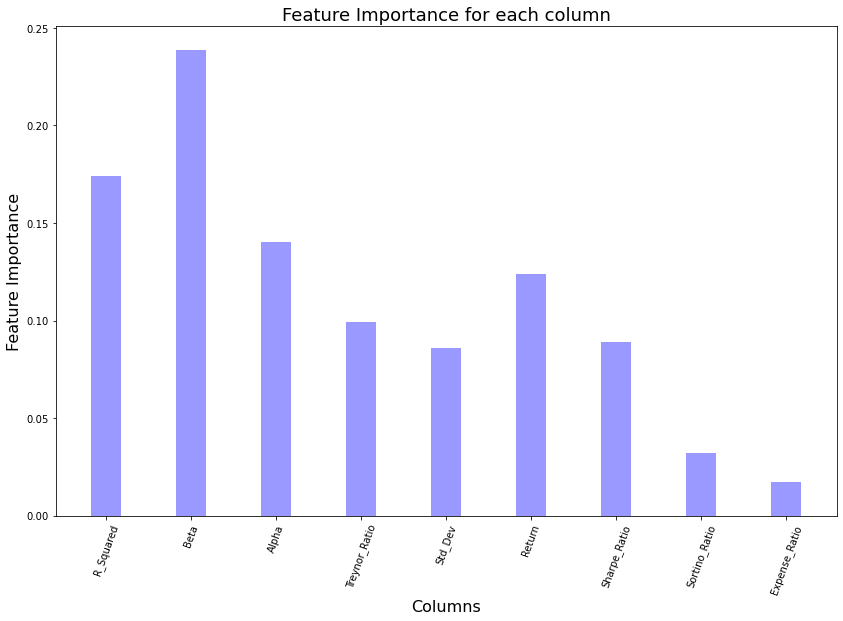

In [16]:
# Show a bar plot of feature imp of named features

index = np.arange(len(columns))
bar_width = 0.35
opacity = 0.4

plt.figure(figsize=(14,9))
plt.bar(index, feature_imp, bar_width,
                 alpha=opacity,
                 color='b',
                 label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column', fontsize =18)
plt.xticks(index, columns,rotation = 70)
plt.show()


Based on the above result we can say that Beta,R squared, Standard deviation and alpha, are the important fearures when determining the good mutual fund.
Now predict good/bad funds based on random forest model fitted for X and Y.

In [17]:
# Predict the result
Y_predict = clf.predict(X)
fund_data['Predicted_result'] = Y_predict
#DEPRECATED: use DataFrame.sort_values() instead of dataframe.sort()
# sort the result in descending order of returns
#good_fund_three_yrs = fund_data.query("Predicted_result==1").sort_values(['Net_returns'],ascending=False).reset_index(drop=True)
#good_fund_three_yrs.sort_values(['Net_returns'])
good_fund_three_yrs = fund_data.query("Predicted_result==1").sort_values(['Net_returns'],ascending=False).reset_index(drop=True)

In [18]:
good_fund_three_yrs.head()

,Fund_Ticker,Benchmark_Index,R_Squared,Beta,Alpha,Treynor_Ratio,Currency,Year_Trailing,Std_Dev,Return,Sharpe_Ratio,Sortino_Ratio,Expense_Ratio,Net_returns,Predicted_result
0,PSPTX,S&P 500 TR USD,92.11,1.05,2.54,23.83,USD,3,9.87,25.03,2.33,4.81,0.640000,24.390000,1
1,PIXAX,S&P 500 TR USD,90.71,1.06,2.62,23.91,USD,3,10.01,25.28,2.32,4.59,1.190000,24.090000,1
2,FSMVX,S&P 500 TR USD,87.41,1.10,1.13,22.18,USD,3,10.60,24.37,2.12,4.36,0.720000,23.650000,1
3,FLCSX,S&P 500 TR USD,92.80,1.10,0.51,21.53,USD,3,10.33,23.76,2.13,4.13,0.913333,22.846667,1
4,VFTSX,S&P 500 TR USD,95.11,1.06,0.70,21.72,USD,3,9.83,23.10,2.17,4.26,0.280000,22.820000,1


Now Show Top performing 20 funds for investment.

In [19]:
good_fund_three_yrs[:20]

,Fund_Ticker,Benchmark_Index,R_Squared,Beta,Alpha,Treynor_Ratio,Currency,Year_Trailing,Std_Dev,Return,Sharpe_Ratio,Sortino_Ratio,Expense_Ratio,Net_returns,Predicted_result
0,PSPTX,S&P 500 TR USD,92.11,1.05,2.54,23.83,USD,3,9.87,25.03,2.33,4.81,0.640000,24.390000,1
1,PIXAX,S&P 500 TR USD,90.71,1.06,2.62,23.91,USD,3,10.01,25.28,2.32,4.59,1.190000,24.090000,1
2,FSMVX,S&P 500 TR USD,87.41,1.10,1.13,22.18,USD,3,10.60,24.37,2.12,4.36,0.720000,23.650000,1
3,FLCSX,S&P 500 TR USD,92.80,1.10,0.51,21.53,USD,3,10.33,23.76,2.13,4.13,0.913333,22.846667,1
4,VFTSX,S&P 500 TR USD,95.11,1.06,0.70,21.72,USD,3,9.83,23.10,2.17,4.26,0.280000,22.820000,1
5,PSTKX,S&P 500 TR USD,98.67,1.03,1.34,22.47,USD,3,9.40,23.26,2.28,4.54,0.500000,22.760000,1
6,WOOPX,S&P 500 TR USD,88.74,1.12,0.04,21.01,USD,3,10.74,23.55,2.03,4.02,0.960000,22.590000,1
7,VUVLX,S&P 500 TR USD,93.44,1.05,0.67,21.66,USD,3,9.82,22.79,2.15,4.10,0.290000,22.500000,1
8,VSLPX,S&P 500 TR USD,98.73,1.04,0.42,21.39,USD,3,9.43,22.23,2.18,4.24,0.170000,22.060000,1
9,JIISX,S&P 500 TR USD,96.07,1.06,0.60,21.61,USD,3,9.78,22.97,2.17,4.45,0.970000,22.000000,1



First we will see he relationship between expense ratio and Returns using scatter plot for top performing funds

In [20]:
good_fund_three_yrs.to_json("../out/three_year_top_fund.json")

In [21]:
good_fund_three_yrs.columns

Index(['Fund_Ticker', 'Benchmark_Index', 'R_Squared', 'Beta', 'Alpha',
       'Treynor_Ratio', 'Currency', 'Year_Trailing', 'Std_Dev', 'Return',
       'Sharpe_Ratio', 'Sortino_Ratio', 'Expense_Ratio', 'Net_returns',
       'Predicted_result'],
      dtype='object')

Text(0, 0.5, 'Expense Ratio')

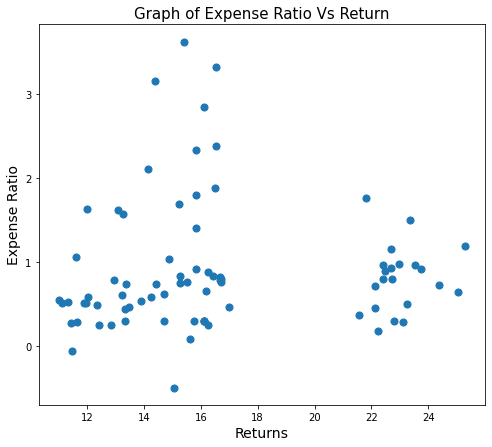

In [22]:
#Plot Returns  Vs Expense ratio
plt.figure(figsize=(8,7))
x=good_fund_three_yrs.Return
y=good_fund_three_yrs.Expense_Ratio
plt.scatter(x,y,s=50)
plt.title("Graph of Expense Ratio Vs Return", fontsize=15)
plt.xlabel("Returns" , fontsize=14)
plt.ylabel("Expense Ratio", fontsize=14)


Now we will Plot a graph of Net Returns Vs Risk (Standard deviation) for good funds using scatter plot.

>>> Esto es la volatilidad

In [23]:
'''
This function plots a graph of Returns Vs Standard deviation

'''
def plot_returns_Vs_risk(good_funds):
    x_arr= good_funds.Net_returns
    y_arr= good_funds.Std_Dev

    plt.figure(figsize=(12,10))

    plt.scatter(x_arr, y_arr)
    plt.xlabel('Net Returns ( Returns - Expense Ratio = Rentabildad menos Comisiones )')
    plt.ylabel('Risk - Volatilidad (Std_Dev)')
    for label, x, y in zip(good_funds.Fund_Ticker, x_arr, y_arr):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (20, -20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'lightblue', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Text(0.5, 1.0, 'Graph of Net Returns Vs Risk (Volatilidad - Std_Dev) for 3 Years')

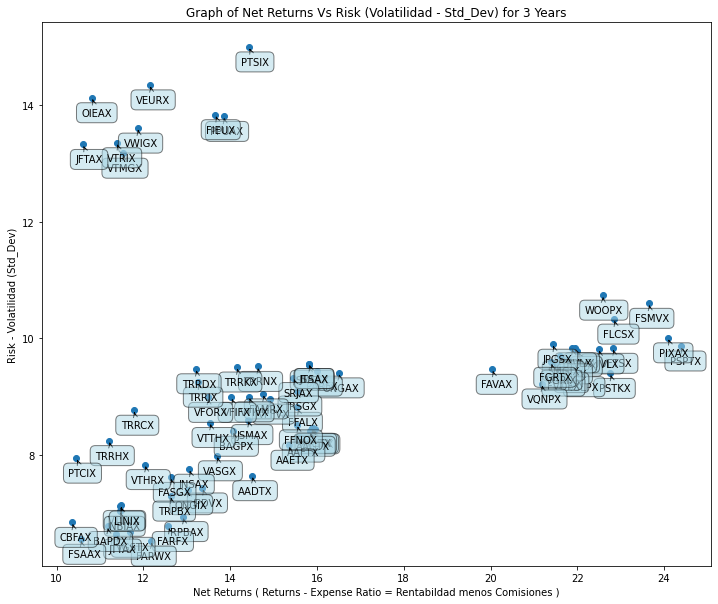

In [24]:
plot_returns_Vs_risk(good_fund_three_yrs)
plt.title("Graph of Net Returns Vs Risk (Volatilidad - Std_Dev) for 3 Years")

As we can see, that the funds are clustured together so the above graph is not readable. We will divide the graph into 3 parts as follows :
Good funds with risk< 10 and returns < 18 %
Good funds with risk >=10 and returns < 18 %
Good funds with risk < 12 and returns > 18 %
1. Good funds with risk< 10 and returns < 18 %

In [25]:
len(good_fund_three_yrs)

79

Text(0.5, 1.0, 'Good funds for 3 Years with risk < 10% and returns < 18%')

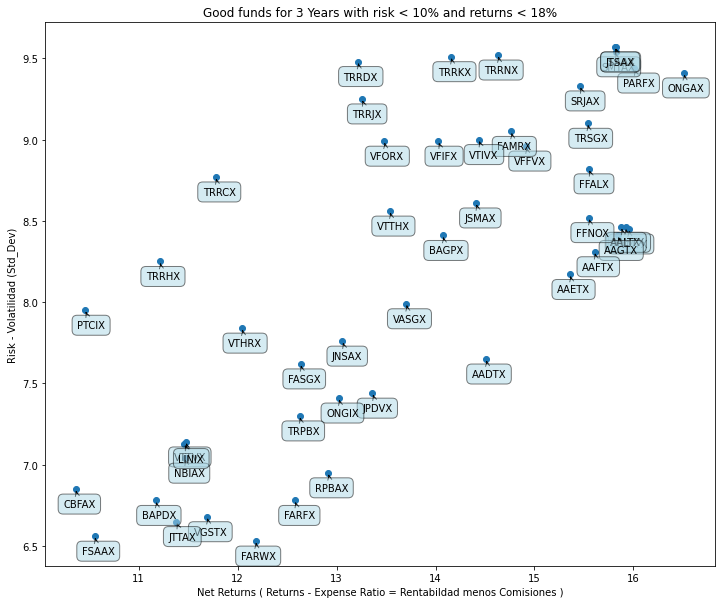

In [26]:
# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_three_yrs.query('Std_Dev<10 & Net_returns < 18')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 3 Years with risk < 10% and returns < 18%")

2.Good funds with risk >=10 and returns < 18 %

Text(0.5, 1.0, 'Good funds for 3 Years with risk >=10 and returns < 18 %')

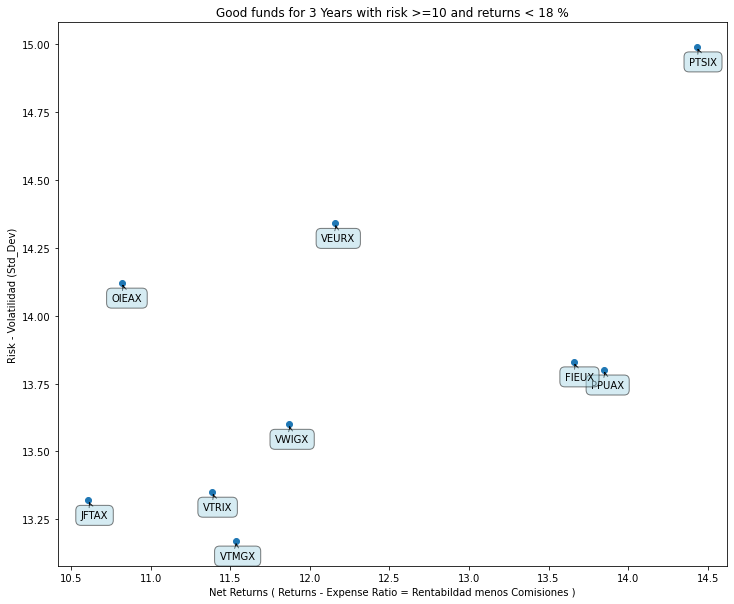

In [27]:
# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_three_yrs.query('Std_Dev>=10 & Net_returns < 18')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 3 Years with risk >=10 and returns < 18 %")

3.Good funds with risk < 12 and returns > 18 %

Text(0.5, 1.0, 'Good funds for 3 Years  with risk < 12 and returns > 18%')

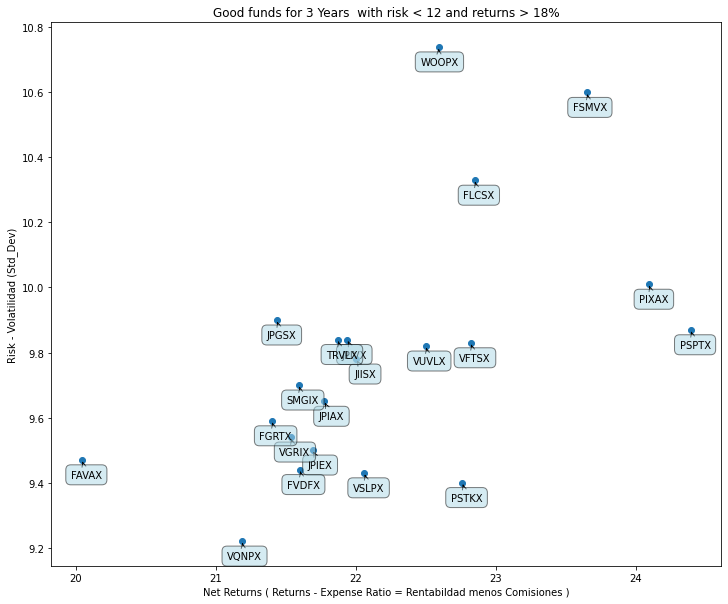

In [28]:
# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_three_yrs.query('Std_Dev<12 & Net_returns > 18')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 3 Years  with risk < 12 and returns > 18%")


1.1.1 More insight into top performing funds for 3 years investment
Now we will pick 5 funds from the top performing funds which we calculated above and see how these funds are behaving this year. We will gather data from yahoo finance for daily returns.
We are using Yahoo finace since daily returns are not avilable on morning start website.
We will consider the following good funds: FAVAX,VQNPX,PSTKX,PSPTX,PIXAX

In [29]:
# deprecated
#import pandas.io.data as web
import pandas_datareader as web

#Comentamos el ejemplo y filtramos datos hasta hoy
#data = web.get_data_yahoo(['FAVAX','VQNPX','PSTKX','PSPTX','PIXAX'], 
#                               start=datetime.datetime(2014, 1, 1), 
#                               end=datetime.datetime(2014, 12, 31))['Adj Close']
data = web.get_data_yahoo(['FAVAX','VQNPX','PSTKX','PSPTX','PIXAX'], 
                               start=datetime.datetime(2004, 1, 1), 
                               end=datetime.datetime(2021, 1, 26))['Adj Close']




data.head()

Symbols,FAVAX,VQNPX,PSTKX,PSPTX,PIXAX
Date,,,,,
2004-01-02,9.115379,20.734327,4.821797,4.885105,NaN
2004-01-05,9.249925,20.980185,4.876141,4.935208,NaN
2004-01-06,9.249925,21.032341,4.886023,4.964434,NaN
2004-01-07,9.258335,21.136644,4.900843,4.985312,NaN
2004-01-08,9.325604,21.158993,4.920605,5.002013,NaN



Calculate Returns using function pct_change()

In [30]:
rets = data.pct_change()
rets.head()

Symbols,FAVAX,VQNPX,PSTKX,PSPTX,PIXAX
Date,,,,,
2004-01-02,NaN,NaN,NaN,NaN,NaN
2004-01-05,0.014760,0.011857,0.011270,0.010256,NaN
2004-01-06,0.000000,0.002486,0.002027,0.005922,NaN
2004-01-07,0.000909,0.004959,0.003033,0.004205,NaN
2004-01-08,0.007266,0.001057,0.004032,0.003350,NaN



Find correlation between the selected funds and plot heat map showing correlation

In [31]:
corr = rets.corr()
corr

Symbols,FAVAX,VQNPX,PSTKX,PSPTX,PIXAX
Symbols,,,,,
FAVAX,1.000000,0.926433,0.890633,0.868436,0.919521
VQNPX,0.926433,1.000000,0.918643,0.895520,0.913673
PSTKX,0.890633,0.918643,1.000000,0.950638,0.949411
PSPTX,0.868436,0.895520,0.950638,1.000000,0.933607
PIXAX,0.919521,0.913673,0.949411,0.933607,1.000000


Text(0.5, 1.0, 'Correlation between Funds')

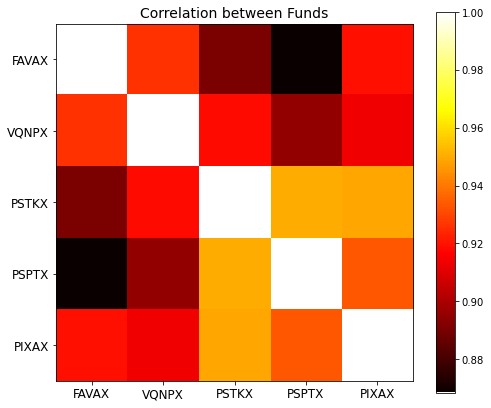

In [32]:
#Plot heat map for correlation
plt.figure(figsize=(8,7))
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, fontsize = 12)
plt.yticks(range(len(corr)), corr.columns, fontsize = 12);
plt.title("Correlation between Funds",fontsize=14)

Show histogram of selected funds

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5ee744a60>,
      dtype=object)

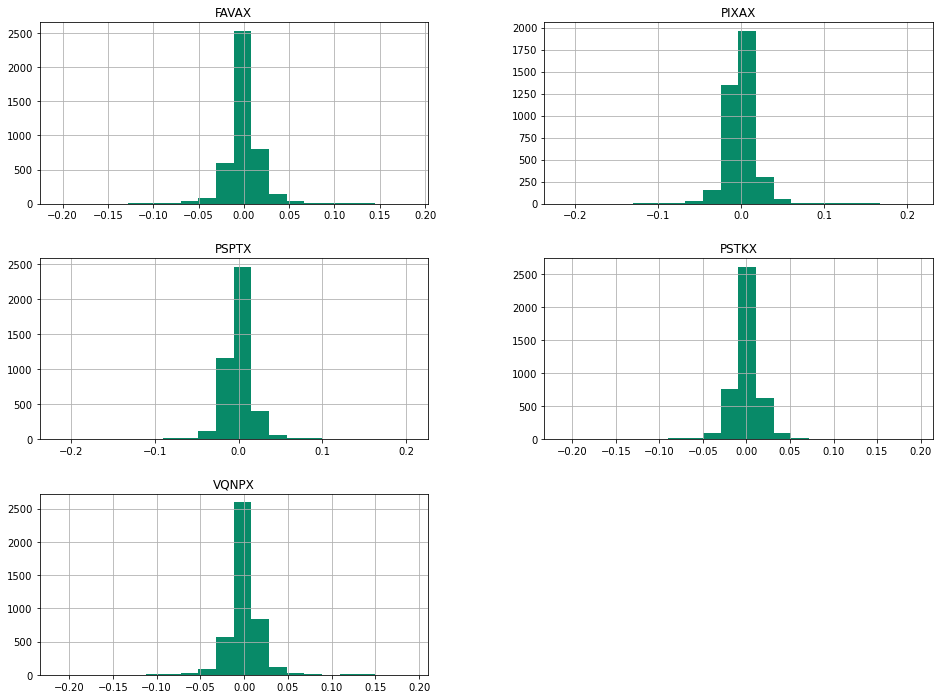

In [33]:
rets.diff().hist(figsize=(16,12),bins=20,color="#088A68")


Show Percentage returns for each fund for current year

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
 <a list of 10 Text major ticklabel objects>)

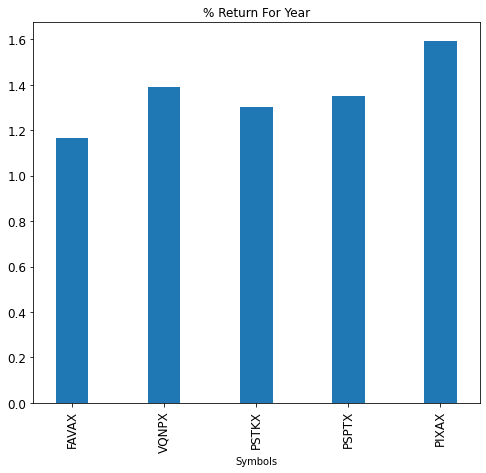

In [34]:
plt.figure(figsize=(8,7))
rets.sum().plot(kind='bar',title="% Return For Year", width=0.35)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


Plot chart of cumulative sum of selcted funds.

Text(0.5, 1.0, 'Rendimiento acumulado a 16 años: (fondos seleccionados en periodo 3 años) ')

<Figure size 1440x720 with 0 Axes>

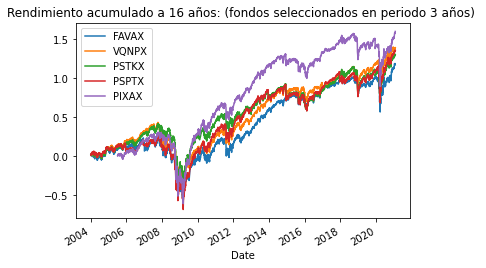

In [35]:
ts = rets.cumsum()
#plt.figure(); ts.plot(); plt.legend(loc='upper left')
plt.figure(2,figsize=[20,10])
ts.plot()
plt.legend(loc='upper left')
plt.title("Rendimiento acumulado a 16 años: (fondos seleccionados en periodo 3 años) ")

From the above analysis we can say that this funds amongst the selected 5 funds, PSPTX is performing slightly better than the rest.